In [1]:
# boilerplate code
import os
import re
from cStringIO import StringIO
import numpy as np
from functools import partial
import PIL.Image
import PIL.ImageOps
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

In [2]:
# creating fresh Graph and TensorFlow session
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

# Prepare input for the format expected by the graph
t_input = tf.placeholder(np.float32, name='our_input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)

# Load graph and import into graph used by our session
model_fn = 'imagenet/tensorflow_inception_graph.pb'
graph_def = tf.GraphDef.FromString(open(model_fn).read())
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [3]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print 'Number of layers', len(layers)
print 'Total number of feature channels:', sum(feature_nums)

Number of layers 59
Total number of feature channels: 7548


In [4]:
# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

In [5]:
label_lookup_path = 'imagenet/imagenet_2012_challenge_label_map_proto.pbtxt'
uid_lookup_path = 'imagenet/imagenet_synset_to_human_label_map.txt'

# The id translation goes via id strings -- find translation between UID string and human-friendly names
proto_as_ascii_lines = open(uid_lookup_path).readlines()
uid_to_human = {}
p = re.compile(r'[n\d]*[ \S,]*')
for line in proto_as_ascii_lines:
    parsed_items = p.findall(line)
    uid = parsed_items[0]
    human_string = parsed_items[2]
    uid_to_human[uid] = human_string

# Get node IDs to UID strings map
proto_as_ascii_lines = open(label_lookup_path).readlines()
node_id_to_uid = {}
for line in proto_as_ascii_lines:
    if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
    if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

# Make node ID to human friendly names map
node_id_to_name = {}
for key, val in node_id_to_uid.iteritems():
    name = uid_to_human[val]
    node_id_to_name[key] = name
    
# make sure we have a name for each possible ID
for i in range(graph.get_tensor_by_name('import/softmax2:0').get_shape()[1]):
    if i not in node_id_to_name:
        node_id_to_name[i] = '???'

In [6]:
node_id_to_name[88] #Inception model has 1000 output classes. Class 88 represents a British breed of dog:

'Norfolk terrier'

In [7]:
# Helper function to get a named layer from the graph
def T(layer_name):
    return graph.get_tensor_by_name("import/%s:0" % layer_name)

softmax = T('softmax2')

def prep_img(filename):
    size = (224, 224)
    img = PIL.Image.open(filename)
    img.thumbnail(size, PIL.Image.ANTIALIAS)
    thumb = PIL.ImageOps.fit(img, size, PIL.Image.ANTIALIAS, (0.5, 0.5))
    return np.float32(thumb)

# Print the 10 top predictions for a given image
def prediction(filename, k=10):
    img = prep_img(filename)
    # Load, resize, and central square crop the image.
    
    # Compute predictions
    predictions = sess.run(softmax, {t_input: img})
    predictions = np.squeeze(predictions)

    top_k = predictions.argsort()[-k:][::-1]
    for node_id in top_k:
        human_string = node_id_to_name[node_id]
        score = predictions[node_id]
        print '%s (score = %.5f)' % (human_string, score)
        
# Helper function: Display an image
def showarray(a, fmt='jpeg', size=None):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = StringIO()
    img = PIL.Image.fromarray(a)
    if size is not None:
        img = img.resize((size,size))
    img.save(f, fmt)
    display(Image(data=f.getvalue()))

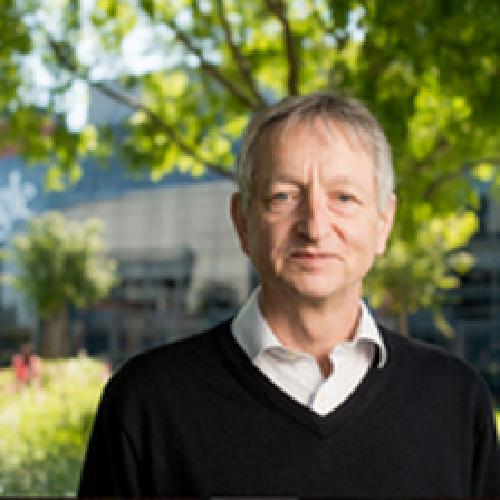

academic gown, academic robe, judge's robe (score = 0.76405)
mortarboard (score = 0.19112)
sweatshirt (score = 0.01131)
suit, suit of clothes (score = 0.00868)
jersey, T-shirt, tee shirt (score = 0.00333)
bulletproof vest (score = 0.00169)
croquet ball (score = 0.00149)
Windsor tie (score = 0.00059)
pinwheel (score = 0.00056)
trench coat (score = 0.00054)


In [8]:
showarray(prep_img('testimages/hinton.jpg')/255., size=500) #Geoffrey Hinton, the godfather of ‘deep learning’
prediction('testimages/hinton.jpg')

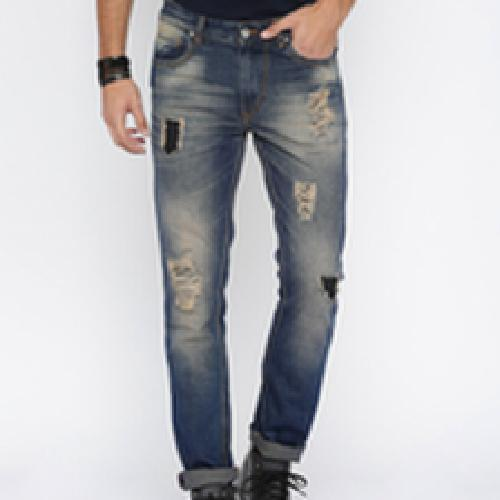

jean, blue jean, denim (score = 0.98944)
cowboy boot (score = 0.00205)
knee pad (score = 0.00147)
suit, suit of clothes (score = 0.00099)
pajama, pyjama, pj's, jammies (score = 0.00083)
cardigan (score = 0.00053)
sweatshirt (score = 0.00038)
bulletproof vest (score = 0.00035)
Windsor tie (score = 0.00027)
stole (score = 0.00026)


In [9]:
showarray(prep_img('testimages/jeans.jpg')/255., size=500) #Correct classification
prediction('testimages/jeans.jpg')

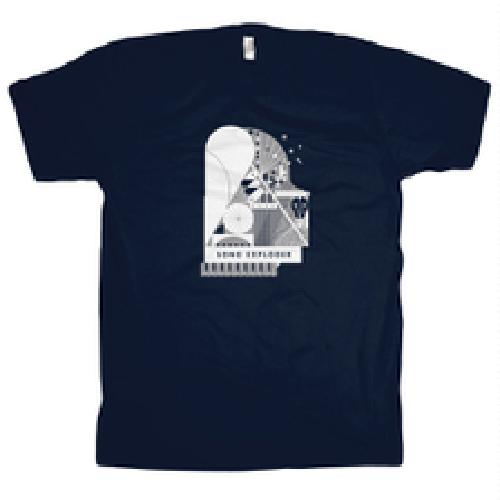

jersey, T-shirt, tee shirt (score = 0.99991)
sweatshirt (score = 0.00009)
maillot (score = 0.00001)
bulletproof vest (score = 0.00000)
abaya (score = 0.00000)
wool, woolen, woollen (score = 0.00000)
apron (score = 0.00000)
sleeping bag (score = 0.00000)
breastplate, aegis, egis (score = 0.00000)
velvet (score = 0.00000)


In [10]:
showarray(prep_img('testimages/tshirt.jpg')/255., size=500) #Correct classification
prediction('testimages/tshirt.jpg')

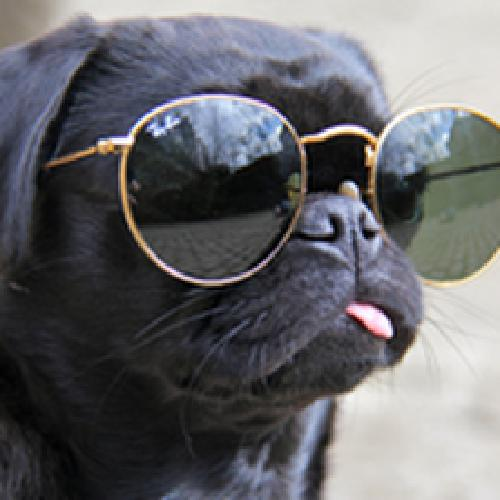

sunglasses, dark glasses, shades (score = 0.88023)
sunglass (score = 0.10082)
pug, pug-dog (score = 0.00651)
muzzle (score = 0.00246)
Labrador retriever (score = 0.00136)
giant schnauzer (score = 0.00128)
Brabancon griffon (score = 0.00119)
bull mastiff (score = 0.00061)
boxer (score = 0.00061)
Newfoundland, Newfoundland dog (score = 0.00041)


In [11]:
showarray(prep_img('testimages/dog.jpg')/255., size=500) #Almost Correct classification but doesn't recognize the dog
prediction('testimages/dog.jpg')

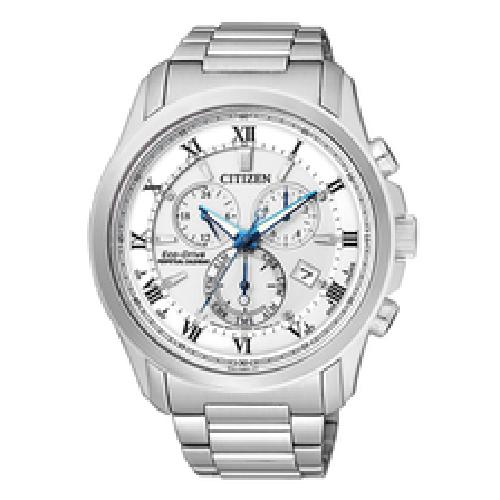

analog clock (score = 0.68373)
stopwatch, stop watch (score = 0.26558)
wall clock (score = 0.03169)
magnetic compass (score = 0.01546)
digital watch (score = 0.00212)
barometer (score = 0.00115)
digital clock (score = 0.00019)
sundial (score = 0.00004)
bell cote, bell cot (score = 0.00002)
rule, ruler (score = 0.00001)


In [12]:
showarray(prep_img('testimages/watch.jpg')/255., size=500) #Confused classification
prediction('testimages/watch.jpg')

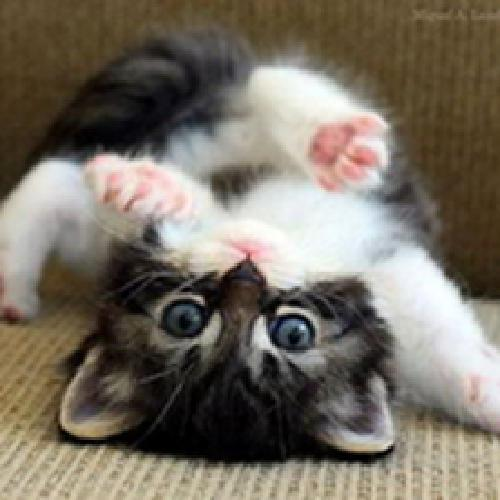

Persian cat (score = 0.75068)
tabby, tabby cat (score = 0.09677)
Angora, Angora rabbit (score = 0.03348)
Egyptian cat (score = 0.02004)
mouse, computer mouse (score = 0.01822)
Old English sheepdog, bobtail (score = 0.01312)
Siamese cat, Siamese (score = 0.00861)
black-footed ferret, ferret, Mustela nigripes (score = 0.00829)
tiger cat (score = 0.00746)
Siberian husky (score = 0.00471)


In [13]:
showarray(prep_img('testimages/kitten.jpg')/255., size=500) #Almost Correct classification
prediction('testimages/kitten.jpg')

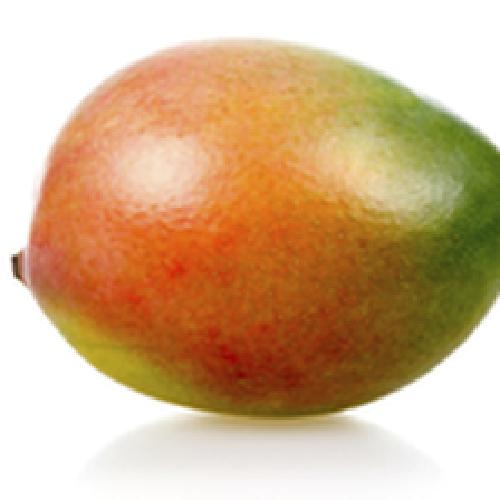

Granny Smith (score = 0.31502)
croquet ball (score = 0.18123)
orange (score = 0.17135)
lemon (score = 0.15191)
pomegranate (score = 0.08000)
banana (score = 0.02487)
spaghetti squash (score = 0.02206)
fig (score = 0.01641)
buckeye, horse chestnut, conker (score = 0.01320)
maraca (score = 0.00539)


In [14]:
showarray(prep_img('testimages/mango.jpg')/255., size=500) #Incorrect classification
prediction('testimages/mango.jpg')